# Classification Modeling - Update

# Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Import modeling tools, pipelines, models, and metrics
import shap

In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

set_config(transform_output='pandas')

# Load Data

In [5]:
df_data = pd.read_parquet('../../data/3.2_data_with_occupancies.parquet')
df_data

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,Country,...,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_DayOfWeek,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,342,2015,July,27,1,2,0.0,0,BB,PRT,...,21,45,21,22,44,3,41,41,0.115169,0.115169
56,149,2015,July,27,1,2,1.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
57,149,2015,July,27,1,2,0.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
58,145,2015,July,27,1,2,0.0,0,HB,GBR,...,21,38,28,56,36,3,41,201,0.115169,0.564607
59,110,2015,July,27,1,3,0.0,0,BB,ESP,...,21,40,26,21,71,3,41,172,0.115169,0.483146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119362,4,2017,August,35,31,2,0.0,0,SC,FRA,...,16,32,19,39,12,4,271,102,0.761236,0.286517
119366,198,2017,August,35,31,2,0.0,0,SC,GBR,...,16,33,18,59,44,4,271,154,0.761236,0.432584
119372,332,2017,August,35,31,2,0.0,0,BB,GBR,...,16,33,18,2,49,4,271,154,0.761236,0.432584
119380,109,2017,August,35,31,2,0.0,0,BB,GBR,...,16,28,23,27,13,4,271,22,0.761236,0.061798


In [6]:
df_data.columns.to_list()

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'Adults',
 'Children',
 'Babies',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'ReservedRoomType',
 'AssignedRoomType',
 'BookingChanges',
 'DepositType',
 'Agent',
 'Company',
 'DaysInWaitingList',
 'CustomerType',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ReservationStatus',
 'HotelNumber',
 'ArrivalDate',
 'DepartureDate',
 'Length of Stay',
 'BookingDate',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepartureDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'BookingDate_DaysAfterHoliday',
 'ArrivalDate_DayOfWeek',
 'occupancy_at_arrival',
 'occupancy_at_departure',
 'occupancy_pct_at_arrival',
 'occupancy_pct_at_departure']

In [7]:
selected_features = ['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'Adults',
 'Children',
 'Babies',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'ReservedRoomType',
 'AssignedRoomType',
 'BookingChanges',
 'DepositType',
 'Agent',
 'Company',
 'DaysInWaitingList',
 'CustomerType',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ReservationStatus',
 'HotelNumber',
 'ArrivalDate',
 'DepartureDate',
 'Length of Stay',
 'BookingDate',
 'ArrivalDate_DaysBeforeHoliday',
 'ArrivalDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'DepartureDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'BookingDate_DaysAfterHoliday',
 'ArrivalDate_DayOfWeek',
 'occupancy_at_arrival',
 'occupancy_at_departure',
 'occupancy_pct_at_arrival',
 'occupancy_pct_at_departure']

In [8]:
df_data = df_data[selected_features]
df_data

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,Country,...,ArrivalDate_DaysAfterHoliday,DepartureDate_DaysBeforeHoliday,DepartureDate_DaysAfterHoliday,BookingDate_DaysBeforeHoliday,BookingDate_DaysAfterHoliday,ArrivalDate_DayOfWeek,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,342,2015,July,27,1,2,0.0,0,BB,PRT,...,21,45,21,22,44,3,41,41,0.115169,0.115169
56,149,2015,July,27,1,2,1.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
57,149,2015,July,27,1,2,0.0,0,BB,IRL,...,21,38,28,60,32,3,41,201,0.115169,0.564607
58,145,2015,July,27,1,2,0.0,0,HB,GBR,...,21,38,28,56,36,3,41,201,0.115169,0.564607
59,110,2015,July,27,1,3,0.0,0,BB,ESP,...,21,40,26,21,71,3,41,172,0.115169,0.483146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119362,4,2017,August,35,31,2,0.0,0,SC,FRA,...,16,32,19,39,12,4,271,102,0.761236,0.286517
119366,198,2017,August,35,31,2,0.0,0,SC,GBR,...,16,33,18,59,44,4,271,154,0.761236,0.432584
119372,332,2017,August,35,31,2,0.0,0,BB,GBR,...,16,33,18,2,49,4,271,154,0.761236,0.432584
119380,109,2017,August,35,31,2,0.0,0,BB,GBR,...,16,28,23,27,13,4,271,22,0.761236,0.061798


# Train/Test Split

In [9]:
target_feature = 'ReservationStatus'

X = df_data.loc[:, selected_features].drop(columns=target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify=y)

In [10]:
y_train.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

In [11]:
y_test.value_counts(normalize=True).round(2)

ReservationStatus
Check-Out    0.63
Canceled     0.37
Name: proportion, dtype: float64

# Random Forest Classifer Model Without Tuning

In [12]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## Create separate pipelines for categorical and numeric features

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=25,
                                                   max_categories = 100))])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced_subsample'))])

model_pipeline.fit(X_train, y_train)

## Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5)

## Evaluate the model using cross_val_score
cv_scores = cross_val_score(model_pipeline, X, y, cv=skf, scoring='f1', n_jobs=-1)

print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')


Cross-Validation Scores: [nan nan nan nan nan]
Mean CV Score: nan
Standard Deviation of CV Scores: nan



## Model Results

              precision    recall  f1-score   support

    Canceled       0.56      0.56      0.56     44224
   Check-Out       0.74      0.74      0.74     75166

    accuracy                           0.67    119390
   macro avg       0.65      0.65      0.65    119390
weighted avg       0.67      0.67      0.67    119390



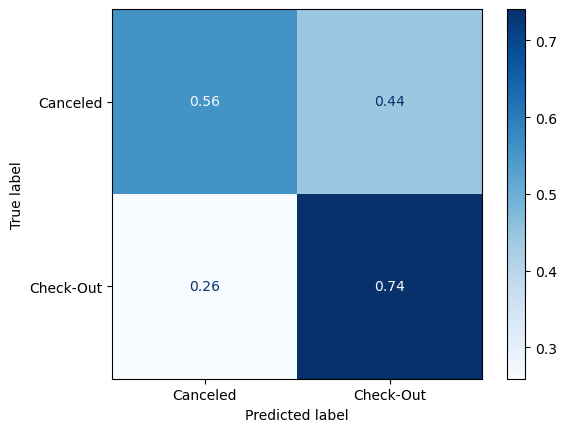

In [15]:
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

print(classification_report(y, y_pred))

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

### Tree Depths

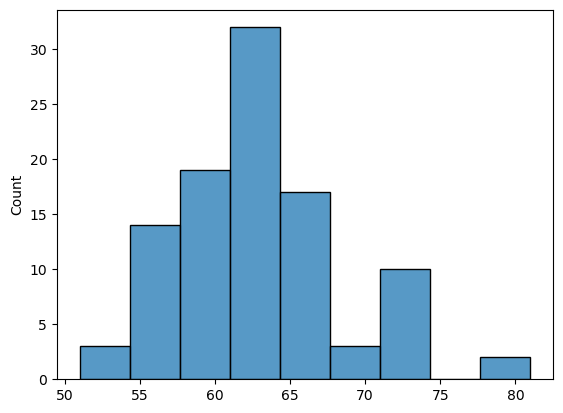

In [16]:
# Access the fitted model
fitted_model = model_pipeline[-1]

# Get the depths of the trees in the fitted model
depths = [tree.get_depth() for tree in fitted_model.estimators_]

# Plot the histogram of tree depths
sns.histplot(depths);

# Random Forest Classifer Model with Tuning

In [23]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## Create separate pipelines for categorical and numeric features

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=10,
                                                   max_categories = 50))])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced_subsample'))])

# Set up hyperparameter tuning 
param_grid = {
    'preprocessor__cat__encoder__min_frequency': [10, 25, 50],
    'preprocessor__cat__encoder__max_categories': [50, 100, 250],
    'classifier__max_depth': [40, 55, 70],
    'classifier__min_samples_split': [2, 3, 4],
    'classifier__min_samples_leaf': [1, 2, 3, 4]
}

# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5)

search = RandomizedSearchCV(model_pipeline,
                            param_distributions=param_grid,
                            scoring='f1_micro',
                            cv=skf,
                            n_iter=50,
                            n_jobs=-1,
                            random_state=42)

# Fit the model and find the best hyperparameters
search.fit(X_train, y_train)

# Extract the best model
best_model = search.best_estimator_

# Evaluate the best model using cross_val_score
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='f1_micro', n_jobs=-1)

print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')

c:\Users\Ben\miniforge3\envs\ds-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

## RFC Model w/ Tuning Results

### Scoring


Training Score: 1.000
Testing Score: 0.905
Difference: 0.095

              precision    recall  f1-score   support

    Canceled       0.94      0.80      0.87     11056
   Check-Out       0.89      0.97      0.93     18792

    accuracy                           0.91     29848
   macro avg       0.91      0.89      0.90     29848
weighted avg       0.91      0.91      0.91     29848



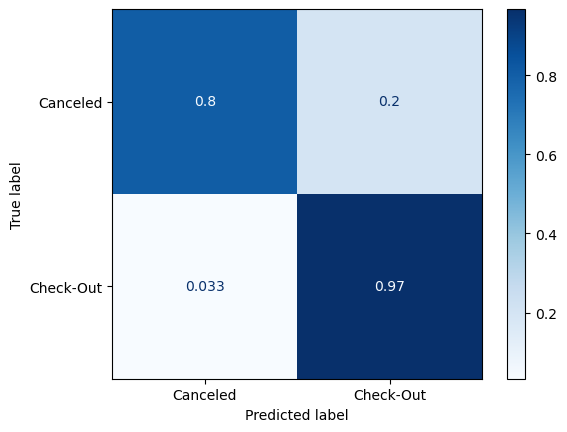

In [20]:
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

print(classification_report(y, y_pred))

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

### Permutation Importances

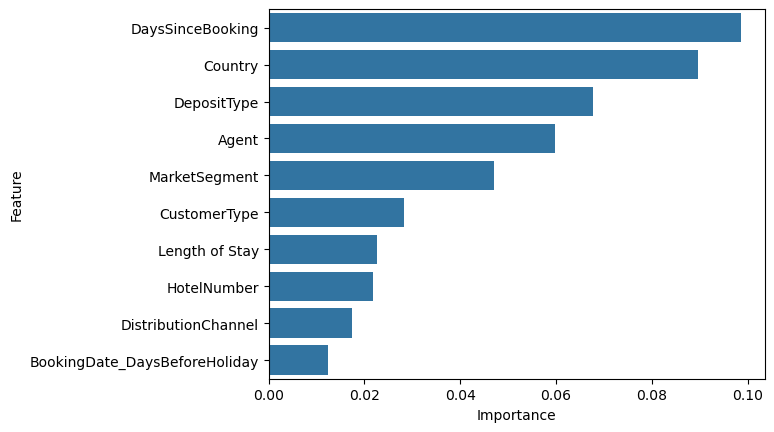

In [21]:
# Calculate permutation importances
result = permutation_importance(best_model,
                                X_test, 
                                y_test,
                                n_jobs=-1,
                                scoring = 'f1')

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - RFC

In [22]:
X_train_xf = best_model.named_steps.preprocessor.fit_transform(X_train)
X_test_xf = best_model.named_steps.preprocessor.transform(X_test)

In [23]:
X_shap_train = shap.sample(X_train_xf, 500)
y_shap_train = y_train.loc[X_shap_train.index]

X_shap_test = shap.sample(X_test_xf, 500)
y_shap_test = y_test.loc[X_shap_test.index]

In [24]:
explainer = shap.Explainer(best_model.named_steps.classifier, X_shap_train)
# shap_values_train = explainer(X_shap_train)
shap_values_test = explainer(X_shap_test)

 99%|===================| 992/1000 [01:56<00:00]        

In [25]:
# print(shap_values_train.shape)
print(shap_values_test.shape)

(500, 613, 2)


### Summary Plot

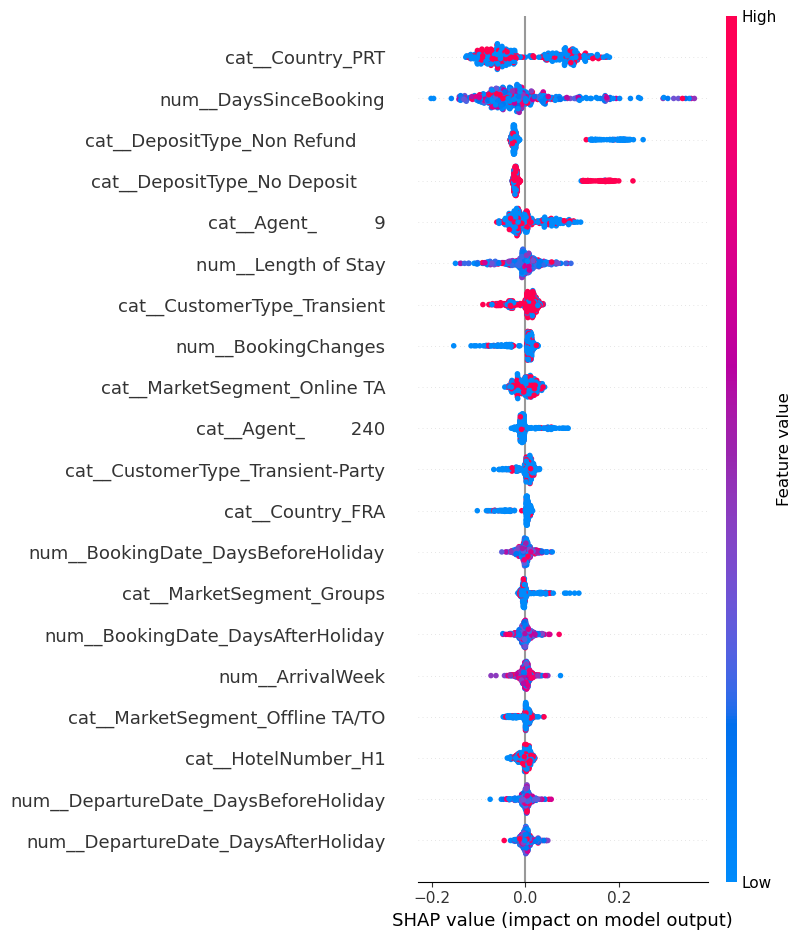

In [26]:
shap.summary_plot(shap_values_test[:, :, 0], X_shap_train)

In [27]:
# df_data.groupby(['Country'])[['ReservationStatus']].value_counts(normalize=True).loc['PRT']

### Force Plot

In [28]:
# For multiple predictions
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# `HistGradientBoostingClassifier` Approach

In [40]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    # ('yeojohnson', PowerTransformer(method='yeo-johnson')),
    # ('scaler', StandardScaler())
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Create the RandomForestClassifier model
classifier = HistGradientBoostingClassifier(class_weight='balanced',
                                            scoring = 'f1_weighted')

hgbr_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    
    # Fit the model and generate predictions
    hgbr_model_pipeline.fit(X_train, y_train)

hgbr_y_pred = hgbr_model_pipeline.predict(X_test)

# Evaluate performance metrics
hgbr_score_training = hgbr_model_pipeline.score(X_train, y_train)
hgbr_score_testing = hgbr_model_pipeline.score(X_test, y_test)


Training Score: 0.897
Testing Score: 0.887
Difference: 0.010

              precision    recall  f1-score   support

    Canceled       0.85      0.84      0.85     11056
   Check-Out       0.91      0.92      0.91     18792

    accuracy                           0.89     29848
   macro avg       0.88      0.88      0.88     29848
weighted avg       0.89      0.89      0.89     29848



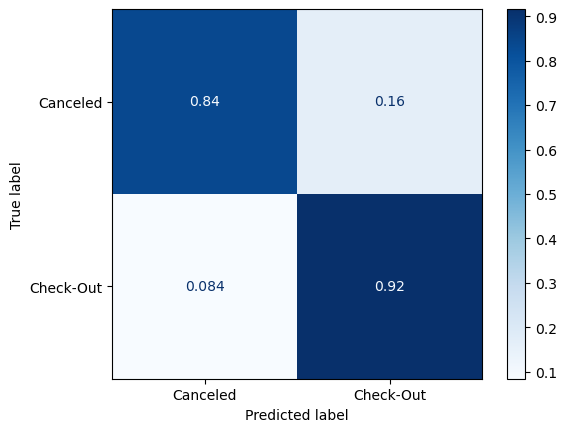

In [41]:
classification_results(model_pipeline = hgbr_model_pipeline,
                       X_train = X_train,
                       X_test = X_test,
                       y_train = y_train,
                       y_test = y_test);

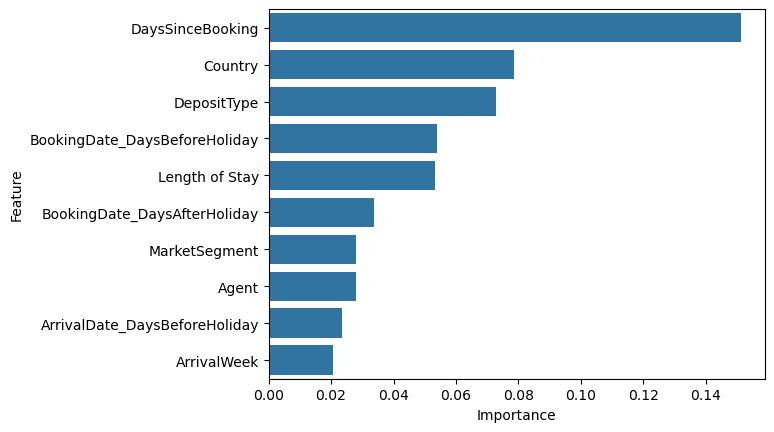

In [31]:
# Calculate permutation importances
result = permutation_importance(hgbr_model_pipeline,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - HGBR

In [32]:
X_train_xf = hgbr_model_pipeline.named_steps.preprocessor.fit_transform(X_train)
X_train_xf

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
97160,-1.732269,1.109945,0.665709,0.530765,-1.331331,-0.087995,-0.421585,0.661362,0.871978,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72545,0.321727,0.199749,0.548211,0.530765,0.073087,-0.087995,-0.421585,0.027864,0.392383,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25753,0.321727,-1.216334,-1.493496,-1.580958,1.550238,-0.087995,-0.421585,-0.188060,-0.943725,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52288,0.321727,2.005286,-1.493496,1.016969,1.550238,-0.087995,-0.421585,1.136227,0.698085,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28348,0.321727,0.404607,1.298882,1.016969,-1.699669,-0.087995,-0.421585,-0.440891,-0.632946,-0.278701,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56864,-1.732269,0.951157,0.283420,-0.482599,-1.420089,-0.087995,-0.421585,0.797399,0.203574,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45645,0.321727,0.372210,1.539847,0.031909,0.832788,-0.087995,-0.421585,1.158488,-0.044071,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94618,0.321727,0.404607,1.298882,1.016969,-1.699669,-0.087995,-0.421585,-0.188060,-0.943725,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118977,0.321727,-0.546763,0.578392,1.492600,0.562228,-0.087995,-0.421585,-1.417519,0.592062,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
X_shap = shap.sample(X_train_xf, 10000)
X_shap

,num__Adults,num__ArrivalDate_DaysAfterHoliday,num__ArrivalDate_DaysBeforeHoliday,num__ArrivalDay,num__ArrivalWeek,num__Babies,num__BookingChanges,num__BookingDate_DaysAfterHoliday,num__BookingDate_DaysBeforeHoliday,num__Children,...,cat__ReservedRoomType_A,cat__ReservedRoomType_B,cat__ReservedRoomType_C,cat__ReservedRoomType_D,cat__ReservedRoomType_E,cat__ReservedRoomType_F,cat__ReservedRoomType_G,cat__ReservedRoomType_H,cat__ReservedRoomType_L,cat__ReservedRoomType_P
23566,0.321727,-0.267148,-0.733142,1.016969,1.097847,-0.087995,-0.421585,-0.497485,-1.927854,-0.278701,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
111024,0.321727,-1.497831,1.089841,1.016969,-0.143833,-0.087995,-0.421585,-1.567886,1.710903,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111104,2.032462,-1.345045,1.067551,1.492600,-0.143833,-0.087995,-0.421585,1.429415,-0.121732,-0.278701,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
31212,0.321727,1.628194,-0.396701,0.031909,-0.992149,-0.087995,-0.421585,-0.497485,1.498214,3.588498,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4116,0.321727,0.615496,1.395192,0.530765,0.899542,-0.087995,-0.421585,-0.098033,1.120828,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19841,0.321727,-1.690375,0.878342,-1.017451,0.493643,-0.087995,-0.421585,-0.987432,-0.943725,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33223,-1.732269,-1.497831,0.548211,-0.482599,-0.594392,-0.087995,-0.421585,-1.567886,-1.474596,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107235,-1.732269,-0.170117,-0.083815,1.016969,-0.441417,-0.087995,-0.421585,0.067704,1.266597,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20152,0.321727,-0.912802,0.721445,-1.580958,0.562228,-0.087995,-0.421585,-0.987432,0.480373,-0.278701,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
y_shap = y_train.loc[X_shap.index]
y_shap

23566      Canceled
111024     Canceled
111104     Canceled
31212     Check-Out
4116       Canceled
            ...    
19841      Canceled
33223     Check-Out
107235     Canceled
20152     Check-Out
86431      Canceled
Name: ReservationStatus, Length: 10000, dtype: object

In [55]:
hgbr_model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  Index(['Adults', 'ArrivalDate_DaysAfterHoliday',
       'ArrivalDate_DaysBeforeHoliday', 'ArrivalDay', 'ArrivalWeek', 'Babies',
       'BookingChanges', 'BookingDate_DaysAfterHoliday',
       'BookingDate_DaysBeforeHoliday', 'Children', 'DaysInWaitingList',
       'DaysSi...
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=200,
                                                                                 sparse_output=False))]),
                                                  Index(['Agent', 'Company', 'Country', 'CustomerType', 'DepositType',
       'DistributionChannel', 'HotelNumber', 'MarketSegment',
       'ReservedRoomType'],
      dtype='object'))])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                scoring='f1_weighted'))])

In [56]:
# explainer = shap.Explainer(hgbr_model_pipeline.named_steps.classifier, X_shap)
explainer = shap.Explainer(hgbr_model_pipeline.named_steps['classifier'])
shap_values = explainer(X_shap)
shap_values.shape

(10000, 613)

## Summary Plot

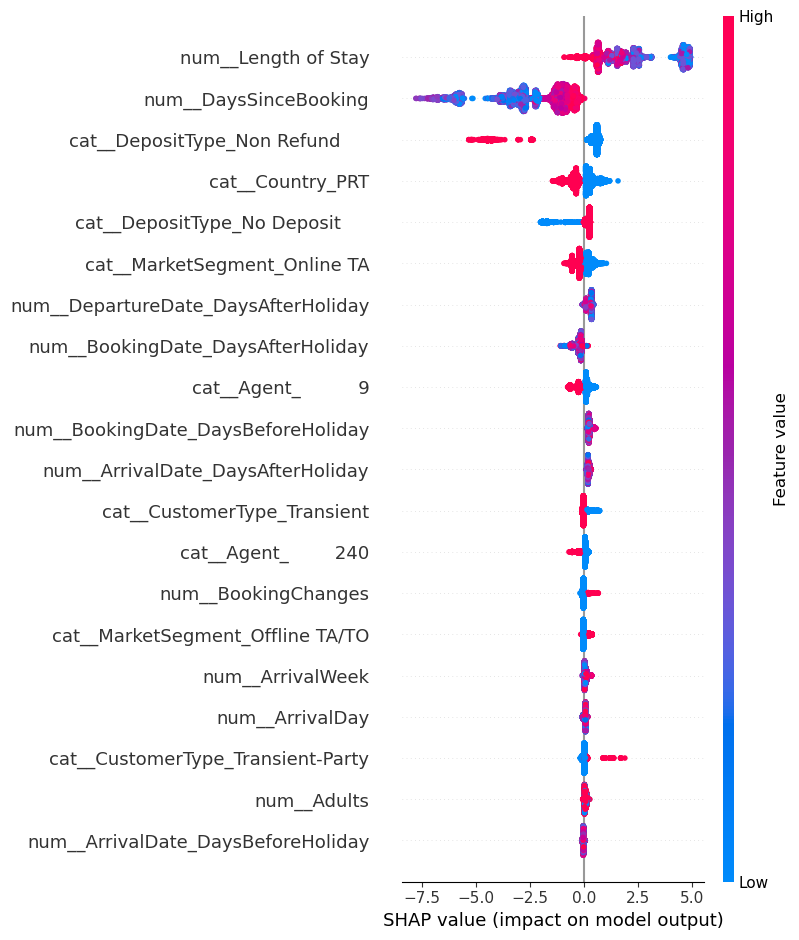

In [57]:
shap.summary_plot(shap_values, X_shap)

# Results and Recommendations

Based on the SHAP results, **we can infer characteristics of guests who are less likely to cancel their reservations.** These characteristics can help define the target market for the hotels to minimize cancellations. Here's an example of an ideal target market:

## Target Market for Minimizing Hotel Reservation Cancellations

1. **Length of Stay**:
   - **Profile**: Guests who book longer stays.
   - **Reason**: Longer stays are associated with a lower likelihood of cancellation.

2. **Days Since Booking**:
   - **Profile**: Guests who book well in advance.
   - **Reason**: A higher number of days since booking indicates a lower likelihood of cancellation.

3. **Deposit Type**:
   - **Profile**: Guests willing to make non-refundable deposits.
   - **Reason**: Non-refundable deposits significantly reduce the likelihood of cancellation.

4. **Country of Origin**:
   - **Profile**: Guests from specific countries like Portugal (PRT).
   - **Reason**: Guests from certain countries show a lower likelihood of cancellation.

5. **Market Segment**:
   - **Profile**: Guests booking through Online Travel Agents (OTA).
   - **Reason**: Bookings through OTAs are less likely to be canceled.


## Example Target Market Persona:

### **1. Business Traveler:**
- **Length of Stay**: 4-7 days
- **Booking Time**: At least 2-3 months in advance
- **Deposit**: Non-refundable
- **Country**: Portugal (PRT) or other identified low-cancellation countries
- **Booking Channel**: Online Travel Agent (OTA)
- **Travel Period**: Not immediately before or after major holidays
- **Customer Type**: Individual transient
- **Booking Changes**: Minimal to no changes post-booking

### **2. Family Vacationers:**
- **Length of Stay**: 5-10 days
- **Booking Time**: 3-6 months in advance
- **Deposit**: Non-refundable
- **Country**: Identified low-cancellation countries (e.g., Portugal)
- **Booking Channel**: OTA or direct website booking
- **Travel Period**: Booking dates that avoid peak holiday disruptions
- **Customer Type**: Transient, not part of group deals
- **Booking Changes**: Stable itinerary with few changes

## Marketing Strategies:

1. **Early Bird Promotions**: Encourage early bookings with attractive discounts for longer stays.
2. **Non-Refundable Deposit Discounts**: Offer special rates for bookings with non-refundable deposits.
3. **Country-Specific Campaigns**: Tailor marketing efforts towards countries with lower cancellation rates.
4. **OTA Partnerships**: Strengthen relationships with online travel agents to attract more reliable bookings.
5. **Holiday Package Adjustments**: Optimize packages and promotions to avoid booking peaks right before or after holidays.
6. **Loyalty Programs for Transient Guests**: Create loyalty programs that cater to individual transient travelers with stable travel plans.
7. **Agent Performance Monitoring**: Monitor and incentivize agents with better non-cancellation records to maintain quality bookings.

By focusing on these customer profiles and implementing targeted marketing strategies, the hotel can effectively reduce reservation cancellations and optimize their booking stability.